# Reducing the Size of a Polygon Shapefile

In this tutorial, we will go through the process of reducing the size of large files (csv, GeoJSON, Shapefiles) that denote polygons or lines. We will use the 'US_Census_2020_zip_code' flat relational table in the CFA data lake. 

In general, this process reduces each spatial object by removing points along the polygon that fall within a certain tolerance. This reduces resolution, but in many cases a lower resolution spatial object is acceptable for the use case and processes much faster. For instance, there are high resolution state boundary maps that contain a point at every meter. This might be necessary if working to determine if a newly-constructed fenceline crosses state boundaries, but in many other cases (such as whether a Chick-Fil-A location is in Georgia or South Carolina), a low-resolution map will suffice. Additionally, processing time and size of datasets grow exponentially with higher resolution vector data.   

Python has tools to simplify polygons, as does ArcGIS. While Alteryx works well for defining points from lat/longs, turning those points into spatial objects, building lines or polygons out of a sequence of points and then reducing them, it can be difficult to go from well-known text to polygon spatial objects. Alteryx requires a multi-step [process](https://community.alteryx.com/t5/Alteryx-Designer-Discussions/WKT-spatial-object-read/td-p/139670) of converting this data - it's possible, but not the simplest action.

In [84]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Point, Polygon
pd.options.mode.chained_assignment = None  # default='warn'

In [85]:
# Read in our dataframe
# 33144 Records - each an individual 
file = pd.read_csv('../../01_Data/01_Initial/us_census_2020_zip_code.csv')

In [86]:
df = file.copy()
df

,wkt_shape,zip_id,zip_geoid,fips_class_code,feature_class_code,functional_status,area_land,area_water,zip_latitude_center,zip_longitude_center,filepath,insert_timestamp,load_date
0,"POLYGON ((-85.596945 39.828736,-85.596897 39.8...",46148,46148,B5,G6350,S,132263262,579218,39.811400,-85.512466,s3://cfadatalakeprod-useast1-dl-common-0089-in...,2021-07-23 12:55:26.368,2021-07-23
1,"POLYGON ((-86.624237 39.908517,-86.624191 39.9...",46149,46149,B5,G6350,S,67965332,34997,39.883138,-86.553505,s3://cfadatalakeprod-useast1-dl-common-0089-in...,2021-07-23 12:55:26.368,2021-07-23
2,"POLYGON ((-85.657275 39.583601,-85.657135 39.5...",46150,46150,B5,G6350,S,63886593,72662,39.545464,-85.602908,s3://cfadatalakeprod-useast1-dl-common-0089-in...,2021-07-23 12:55:26.368,2021-07-23
3,"MULTIPOLYGON (((-86.399251 39.319815,-86.39924...",46151,46151,B5,G6350,S,530294348,10192947,39.457238,-86.433288,s3://cfadatalakeprod-useast1-dl-common-0089-in...,2021-07-23 12:55:26.368,2021-07-23
4,"POLYGON ((-85.431958 39.74269,-85.431882 39.74...",46155,46155,B5,G6350,S,59165,0,39.743501,-85.429741,s3://cfadatalakeprod-useast1-dl-common-0089-in...,2021-07-23 12:55:26.368,2021-07-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33139,"POLYGON ((-90.58616 45.459228,-90.586037 45.45...",54515,54515,B5,G6350,S,214646765,702142,45.512603,-90.491098,s3://cfadatalakeprod-useast1-dl-common-0089-in...,2021-07-23 12:55:26.368,2021-07-23
33140,"POLYGON ((-91.045803 46.069179,-91.045728 46.0...",54517,54517,B5,G6350,S,201377709,11557340,46.145917,-90.930676,s3://cfadatalakeprod-useast1-dl-common-0089-in...,2021-07-23 12:55:26.368,2021-07-23
33141,"POLYGON ((-89.367746 46.041567,-89.36774 46.04...",54519,54519,B5,G6350,S,207743597,22505409,46.050772,-89.262739,s3://cfadatalakeprod-useast1-dl-common-0089-in...,2021-07-23 12:55:26.368,2021-07-23
33142,"POLYGON ((-89.046875 45.60096,-89.046868 45.60...",54520,54520,B5,G6350,S,370296735,28433835,45.547503,-88.892840,s3://cfadatalakeprod-useast1-dl-common-0089-in...,2021-07-23 12:55:26.368,2021-07-23


In [87]:
# Reduce to only the columns that we need
cols = ['wkt_shape', 'zip_id', 'zip_geoid']
df = df[cols]

### Size 
The initial file size is 1.2 GB and needs to be reduced for our use case -  Additionally, the size of the character length is prohibitive, with over 1M characters used to define a polygon. 

In [89]:
geom_lengths = df['wkt_shape'].str.len()
print('Max Characters:', max(geom_lengths))

Max Characters: 1047623


### Convert to Spatial
We can use the Shapely 'well-known text' library to convert the text in `wkt_shape` into a queryable spatial object. While the output looks the same, it is now defined and recognized as a serialized spatial object. Some tools will automatically identify well-known text, but Python uses the Shapely library to convert the string into a spatial object.  We will rename this column `geometry`, as that is convention. 

In [90]:
df

,wkt_shape,zip_id,zip_geoid
0,"POLYGON ((-85.596945 39.828736,-85.596897 39.8...",46148,46148
1,"POLYGON ((-86.624237 39.908517,-86.624191 39.9...",46149,46149
2,"POLYGON ((-85.657275 39.583601,-85.657135 39.5...",46150,46150
3,"MULTIPOLYGON (((-86.399251 39.319815,-86.39924...",46151,46151
4,"POLYGON ((-85.431958 39.74269,-85.431882 39.74...",46155,46155
...,...,...,...
33139,"POLYGON ((-90.58616 45.459228,-90.586037 45.45...",54515,54515
33140,"POLYGON ((-91.045803 46.069179,-91.045728 46.0...",54517,54517
33141,"POLYGON ((-89.367746 46.041567,-89.36774 46.04...",54519,54519
33142,"POLYGON ((-89.046875 45.60096,-89.046868 45.60...",54520,54520


In [91]:
df['geometry'] = df.wkt_shape.apply(wkt.loads)

In [92]:
# Drop WKT column
df.drop('wkt_shape', axis=1, inplace=True) 

In [93]:
# Geopandas GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [94]:
# Left with zip_id and geometry object in spatial dataframe
gdf

,zip_id,zip_geoid,geometry
0,46148,46148,"POLYGON ((-85.59695 39.82874, -85.59690 39.833..."
1,46149,46149,"POLYGON ((-86.62424 39.90852, -86.62419 39.908..."
2,46150,46150,"POLYGON ((-85.65727 39.58360, -85.65713 39.583..."
3,46151,46151,"MULTIPOLYGON (((-86.39925 39.31981, -86.39924 ..."
4,46155,46155,"POLYGON ((-85.43196 39.74269, -85.43188 39.742..."
...,...,...,...
33139,54515,54515,"POLYGON ((-90.58616 45.45923, -90.58604 45.459..."
33140,54517,54517,"POLYGON ((-91.04580 46.06918, -91.04573 46.069..."
33141,54519,54519,"POLYGON ((-89.36775 46.04157, -89.36774 46.041..."
33142,54520,54520,"POLYGON ((-89.04688 45.60096, -89.04687 45.604..."


### Test the Impact of Simplification
The Geopandas `simplify` [documentation](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.simplify.html) function is relatively simple to use, although fine-tuning the appropriate tolerance for specific use cases can be difficult. Tolerance is in the units of the dataset, which in this case is lat/long. We want to preserve topology to avoid erroneous polygons. 

We will test a random polygon and look at the impact of different simplification tolerances. Note that this example has a saw-tooth boundary on the bottom left and right, which we will try to eliminate through simplification. Additionally, this polygon has 33.5k characters, which we can use as a rough baseline to see how our data is reducing. 

In [96]:
# Copy of GDF with first thirty lines for testing
gdf_simplified = gdf[0:30]

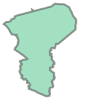

In [97]:
gdf_simplified.geometry[8]

In [98]:
len(str(gdf_simplified.geometry[8]))

33512

### Tests
As we can see, setting a tolerance of 1 is too high - it simplified the polygon to just four points, which is much too rough for our purposes. We can see the transition of the polygon as we reduce the tolerance - at values of 1, 0.5 and 0.05, there is no difference - however, reducing the tolerance to 0.005 approximates the shape of the polygon to what might be a usable format. Further reduction to 0.0005 brings the polygon back to it's original shape. 

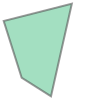

In [99]:
simplified = gdf_simplified.simplify(1)
simplified[8]

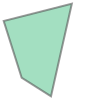

In [100]:
simplified = gdf_simplified.simplify(0.5)
simplified[8]

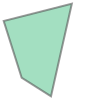

In [101]:
simplified = gdf_simplified.simplify(0.05)
simplified[8]

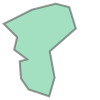

In [102]:
simplified = gdf_simplified.simplify(0.005)
simplified[8]

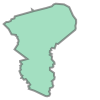

In [103]:
simplified = gdf_simplified.simplify(0.0005)
simplified[8]

### Export
If we reduce the polygons using the 0.005 tolerance, the character length of our longest polygon sequence reduces from 1.2M down to around 700, which is much more manageable. When exporting, the 1.2GB file is now reduced down to 129MB, and renders much quicker in the software we read it into for testing (Tableau, QGIS, ArcGIS). 

In [104]:
# Reset GDF Simplified
gdf_simplified = gdf

In [105]:
x = pd.DataFrame(gdf_simplified.simplify(0.0005))

In [106]:
gdf_simplified['geometry'] = x[0]

In [107]:
gdf_simplified

,zip_id,zip_geoid,geometry
0,46148,46148,"POLYGON ((-85.59695 39.82874, -85.59629 39.860..."
1,46149,46149,"POLYGON ((-86.62424 39.90852, -86.62398 39.909..."
2,46150,46150,"POLYGON ((-85.65727 39.58360, -85.65448 39.584..."
3,46151,46151,"MULTIPOLYGON (((-86.39925 39.31981, -86.39674 ..."
4,46155,46155,"POLYGON ((-85.43196 39.74269, -85.43106 39.744..."
...,...,...,...
33139,54515,54515,"POLYGON ((-90.58616 45.45923, -90.58366 45.461..."
33140,54517,54517,"POLYGON ((-91.04580 46.06918, -91.04552 46.069..."
33141,54519,54519,"POLYGON ((-89.36775 46.04157, -89.36711 46.097..."
33142,54520,54520,"POLYGON ((-89.04688 45.60096, -89.04678 45.637..."


In [108]:
# For other purposes, .csv should have header
gdf_simplified.to_file("../../01_Data/02_GeoJSON/census_2020_Zip.geojson", driver='GeoJSON')

### Result
The image below is the simplified polygon, which renders much faster yet still keeps the general shape of all the polygons. In a limited test of identifying the store locations within zip codes in the state of Georgia, the simplified polygon maintained an accuracy rate of 97% versus the high resolution polygon file we started with - most errors occurred when the store was located in a sliver of land that was cut off in the simplified polygons. 

That was the technical process of reducing the size of a polygon spatial file while maintaining prominent features. However, the caveat here is whether this process is even necessary. Before conducting ETL or building a machine learning model, determine whether high resolution vector data is needed. While a civil engineer maintaining road dimensions will likely have to work with sub-meter resolution vector data and custom projections, determining distance from stores to suppliers in the unit of miles can be rendered much faster and easier using lower-resolution data. Data, such as zip code spatial file we just worked with, is offered by the Census Bureau at three different levels of [resolution](https://www.census.gov/programs-surveys/geography/geographies/mapping-files.2020.List_230945507.html). If necessary, you can use the tools built here to test high and low resolution data for your use case in Python - if the low-resolution data suffices, use that. 

![x](./im_03_01.png)